# Choosing parameters for network simulation

## Goals
Here, I used SiPhyNetwork (https://github.com/jjustison/SiPhyNetwork) to simulate networks and try various sets of parameters to determine which to continue with for my project examining how rate variation affects network/hybridization inference.

## Assumptions

### From SiPhyNetwork
List below taken from the SiPhyNetwork introduction page:
- `frac = 1` and `stochsampling = FALSE` assumes that all extant taxa are sampled in the phylogeny.
- `mrca=TRUE` means that we start with a single lineage rather than the MRCA of two lineages
- `complete = FALSE` removes extinct species on the phylogeny.
- `trait.model = NULL` assumes that successful hybridization events do not depend on a trait value between taxa.

### From simulatedata.jl
Added filters of simulatedata.jl script:
- Exclude trees
- Exclude networks with more than `hmax` reticulations. By default `hmax = ntaxa/2`.
- Exclude networks of level higher than `levelmax`. By default `levelmax = hmax`.
- Shrink 2-cycles and 3-cycles

## Parameters

### Tested
Those I tried various values of:
- **inheritance.fxn**: The function that describes how inheritance probabilities are drawn. Example was make.beta.draw(10,10), I changed to `make.beta.draw(2,2)`. I also tried `make.beta.draw(5,5)`
- **gen_dist_fxn**: Instead of assuming successful hybridization events are not a function of the genetic distance between taxa (`hyb.rate.fxn = NULL`), successful hybridization events were a stepwise function of the genetic distance between taxa `gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))`. 
    - I tested two different locations of the step location, 0.75 and 0.5. 0.75 is where the step is for the final parameter sets.
- **nu**: The hybridization rate. I tried values 0.2, 0.3, 0.4, and am using 0.3 for the final parameter set.

### Not-tested
Those I didn't test various values:
- **hybprops**: A vector of length three that denotes the proportion of hybridizations that are lineage generative, lineage degenerative, and lineage neutral. Used `hybridproportions = [0.5,0.25,0.25]  # generative, degenerative, neutral`
- **lambda**: The speciation rate. Used default value of 1.
- **mu**: The extinction rate. Used default value of 0.2.

## Final parameter sets
1. 4 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2
2. 7 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2
3. 17 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2

In [1]:
include("simulatedata.jl")
using Statistics
using Plots
using RCall
using PhyloPlots
using DelimitedFiles

julia version: 1.6.1
R version 4.1.2 (2021-11-01)
SiPhyNetwork version: v0.0.0.9000
SiPhyNetwork commit sha: 634adb851e185542b0f0737cd193360ab9a10088
done reading this awesome file


In [2]:
#returns tuple with allgammas list and allh list
function summarystats(networks::AbstractArray)
    allgammas = Float64[]
    allh = Int[]
    for net in networks
        append!(allgammas, [e.gamma for e in net.edge if e.hybrid && e.isMajor])
        push!(allh, net.numHybrids)
    end
    return allgammas, allh
end

# simulate networks, get mean values of h, gamma, and levels and visualize distribution
function simulate_visualize(ntaxa::Int, nsims::Int, nu=0.2, fileroot=nothing; plot=true)
    # simulate networks if the output files don't exist yet
    if !isfile("$fileroot.phy") || !isfile("$(fileroot)_levels.csv") || filesize("$fileroot.phy") == 0 
        networks, levels = simulatenetwork(ntaxa, nsims, nu=nu, file="$fileroot.phy", verbose=false)
        writedlm("$(fileroot)_levels.csv", levels)
    else
        networks = readMultiTopology("$fileroot.phy")
        levels = readdlm("$(fileroot)_levels.csv")
        levels = reshape(levels, (size(levels,1),)) # to transform matrix into vector
    end

    #visualize h distribution, get mean h
    allgammas, allh = summarystats(networks)
    if plot
      display(histogram(allh, size = (500, 300), tickfontsize=14, label="h"))
      #visualize gamma distribution, get mean gamma
      display(histogram(allgammas, bins=0.5:.02:1.0, size = (500, 300), tickfontsize=14, label="major gamma"))
      #visualize level distribution, get mean level
      display(histogram(levels, size = (500, 300), tickfontsize=14, label="level")) 
    end
    @show mean(allh)
    @show mean(allgammas)
    @show mean(levels)
    
    return networks, levels
end

simulate_visualize (generic function with 3 methods)

# Final parameter sets

## 4 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2

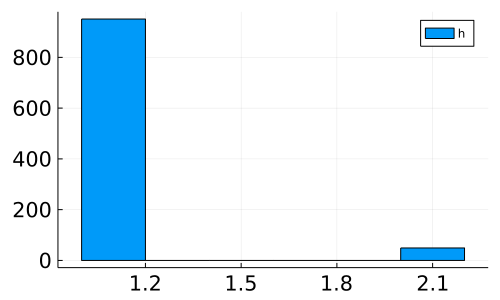

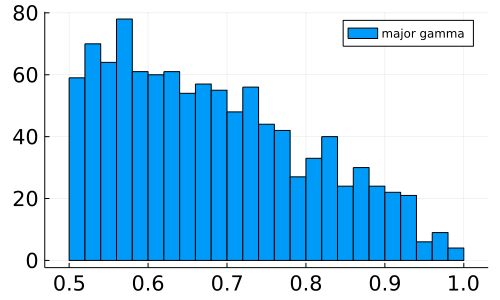

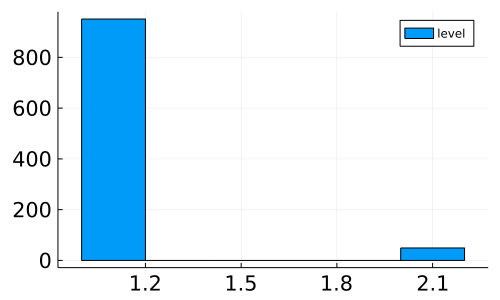

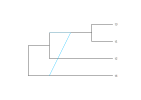

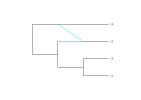

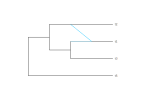

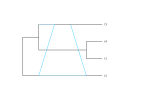

mean(allh) = 1.049
mean(allgammas) = 0.6831209580488983
mean(levels) = 1.049


In [3]:
# external variables: change step to 0.75, beta distribution to 2,2
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(2, 2)"
networks, levels = simulate_visualize(4, 1000, 0.3, "nu0.3_step0.75_beta2_2_4taxa")
#=
seed for the generation of random seeds: 3258
h=1 or 2, never higher
mean(allh) = 1.049
mean(allgammas) = 0.6831209580488983
mean(levels) = 1.049
=#

#plot networks- 3 with 1 hybridization event, 1 with 2 hybridization events
net_idxs = findall(n -> n.numHybrids == 1, networks)[1:3]
push!(net_idxs, findfirst(n -> n.numHybrids == 2, networks))
for i in net_idxs
    display(PhyloPlots.plot(networks[i]))
end

## 7 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2

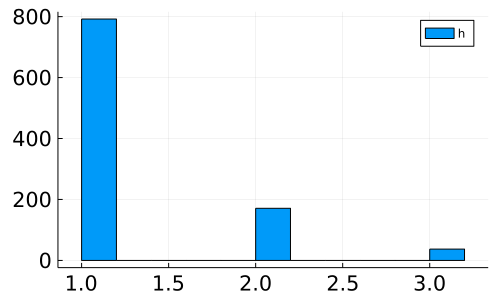

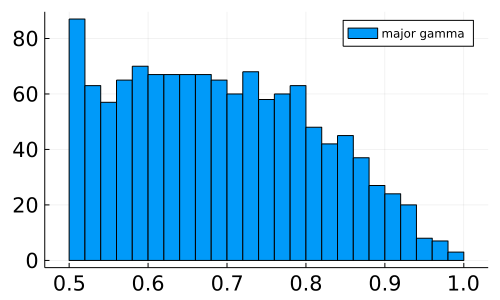

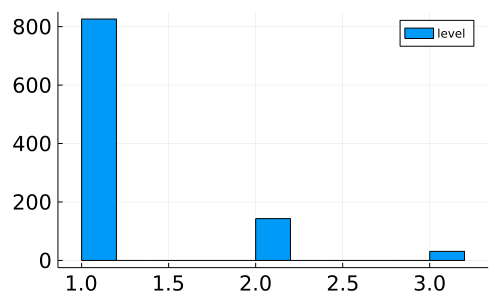

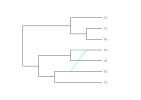

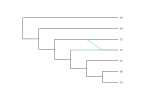

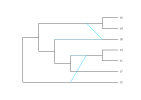

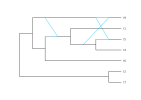

mean(allh) = 1.245
mean(allgammas) = 0.6917879160380902
mean(levels) = 1.205


In [4]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(2, 2)"
networks, levels = simulate_visualize(7, 1000, 0.3, "nu0.3_step0.75_beta2_2_7taxa")
#=
seed for the generation of random seeds: 9878
h=1,2,3 never higher
mean(allh) = 1.245
mean(allgammas) = 0.6917879160380902
mean(levels) = 1.205
=#

#plot networks- 2 with 1 hybridization event, 1 with 2 hybridization events, 1 with 3 hybridization events
net_idxs = findall(n -> n.numHybrids == 1, networks)[1:2]
push!(net_idxs, findfirst(n -> n.numHybrids == 2, networks))
push!(net_idxs, findfirst(n -> n.numHybrids == 3, networks))
for i in net_idxs
    display(PhyloPlots.plot(networks[i]))
end

## 17 taxa, 1000 networks, nu = 0.3, step = 0.75, beta.draw = 2,2

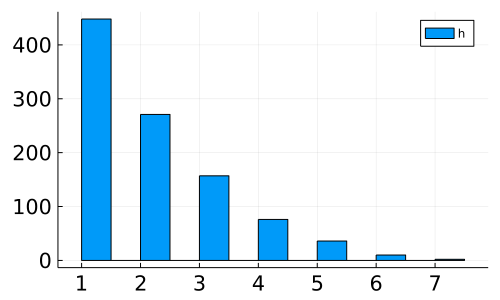

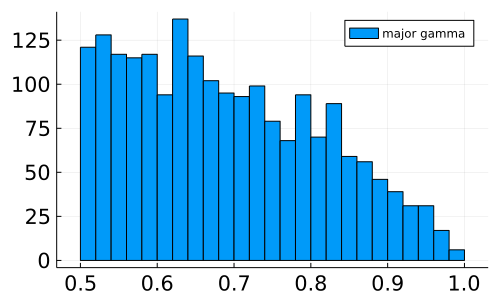

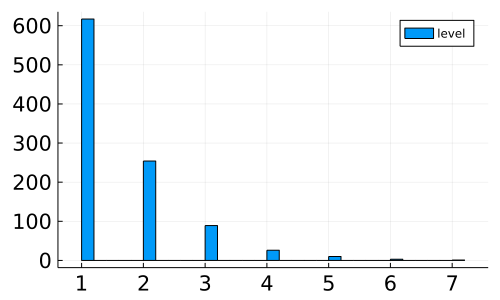

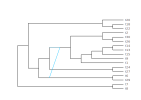

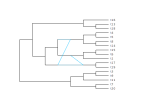

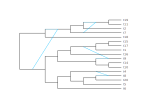

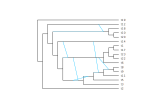

mean(allh) = 2.019
mean(allgammas) = 0.689209761127843
mean(levels) = 1.571


In [5]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(2, 2)"
networks, levels = simulate_visualize(17, 1000, 0.3, "nu0.3_step0.75_beta2_2_17taxa")
#=
seed for the generation of random seeds: 4235
h in [1,7], never higher
mean(allh) = 2.019
mean(allgammas) = 0.6892097611278429
mean(levels) = 1.571
=#

#plot networks- 1 with 1 hybridization event, 1 with 2 hybridization events, 
# 1 with 4 hybridization events, 1 with 6 hybridization events
net_idxs = [findfirst(n -> n.numHybrids == 1, networks),
            findfirst(n -> n.numHybrids == 2, networks),
            findfirst(n -> n.numHybrids == 4, networks),
            findfirst(n -> n.numHybrids == 6, networks)]
for i in net_idxs
    display(PhyloPlots.plot(networks[i]))
end

# Parameter sets w/ 17 taxa, beta draw 5,5

## 17 taxa, 100 networks, nu= 0.2, step 0.5, beta.draw = 5,5

In [6]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.5,Inf))"
R"inheritance_fxn = make.beta.draw(5, 5)"
networks, levels = simulate_visualize(17, 100, 0.2, "nu0.2_step0.5_beta5_5"; plot=false);
#=
seed for the generation of random seeds: 9679
h=1,2,3
mean(allh) = 1.21
mean(allgammas) = 0.6213865787206614
mean(levels) = 1.1
=#

mean(allh) = 1.21
mean(allgammas) = 0.6213865787206614
mean(levels) = 1.1


## 17 taxa, 100 networks, nu = 0.2, step = 0.75, beta.draw = 5,5

In [8]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(5, 5)"
networks, levels = simulate_visualize(17, 100, 0.2, "nu0.2_step0.75_beta_5_5", plot=false);
#=
seed for the generation of random seeds: 6036
mean(allh) = 1.47
mean(allgammas) = 0.6342838634068027
mean(levels) = 1.25
=#

mean(allh) = 1.47
mean(allgammas) = 0.6342838634068027
mean(levels) = 1.25


## 17 taxa, 100 networks, nu = 0.3, step = 0.5, beta.draw = 5,5

In [10]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.5,Inf))"
R"inheritance_fxn = make.beta.draw(5, 5)"
fileroot = 
networks, levels = simulate_visualize(17, 100, 0.3, "nu0.3_step0.5_beta_5_5", plot=false);
#=
seed for the generation of random seeds: 5669
h=1,2,3
mean(allh) = 1.46
mean(allgammas) = 0.6290922865150411
mean(levels) = 1.21
=#

mean(allh) = 1.46
mean(allgammas) = 0.6290922865150411
mean(levels) = 1.21


## 17 taxa, 100 networks, nu = 0.3, step = 0.75, beta.draw = 5,5

In [12]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(5, 5)"
networks, levels = simulate_visualize(17, 100, 0.3, "nu0.3_step0.75_beta5_5", plot=false);
#=
seed for the generation of random seeds: 5951
mean(allh) = 1.98
mean(allgammas) = 0.6163833288937085
mean(levels) = 1.49
=#

mean(allh) = 1.98
mean(allgammas) = 0.6163833288937085
mean(levels) = 1.49


# Parameter sets w/ 7 taxa, beta draw 2,2

## 7 taxa, 1000 networks, nu = 0.4, step = 0.75, beta.draw = 2,2

In [14]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.75,Inf))"
R"inheritance_fxn = make.beta.draw(2, 2)"
networks, levels = simulate_visualize(7, 1000, 0.4, "nu0.4_step0.75_beta2_2", plot=false);
#=
seed for the generation of random seeds: 4813
mean(allh) = 1.331
mean(allgammas) = 0.6952867265136667
mean(levels) = 1.272
=#

mean(allh) = 1.331
mean(allgammas) = 0.6952867265136667
mean(levels) = 1.272


## 7 taxa, 1000 networks, nu = 0.3, step = 0.5, beta.draw = 2,2

In [16]:
R"gen_dist_fxn = make.stepwise(probs = c(1,0),distances = c(0.5,Inf))"
R"inheritance_fxn = make.beta.draw(2, 2)"
networks, levels = simulate_visualize(7, 1000, 0.3, "nu0.3_step0.5_beta2_2", plot=false);
#=
seed for the generation of random seeds: 8389
mean(allh) = 1.176
mean(allgammas) = 0.6855255022042596
mean(levels) = 1.138
=#

mean(allh) = 1.176
mean(allgammas) = 0.6855255022042596
mean(levels) = 1.138
